In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!pip install explainerdashboard --quiet
!pip install missingno --quiet

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
import sys
from datetime import date, timedelta, datetime

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno

# Warn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Model
from joblib import load
import pickle
from tensorflow.keras.models import load_model


#1.0 Loading and Proprocessing New Dataset


In [34]:
# Load new customer dataset -----------------------------------------------------------------------------------------
raw_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/kpmg/Raws/KPMG_VI_New_raw_data_update_final.xlsx',  sheet_name=['NewCustomerList'])
NewCustomer_df = raw_df.get('NewCustomerList')
cols = ['DOB', 'gender', 'wealth_segment','state', 'job_title', 'job_industry_category', 'owns_car', 'past_3_years_bike_related_purchases',
        'tenure','property_valuation','Rank','Value']

cat_cols = ['gender', 'wealth_segment','state', 'job_title', 'job_industry_category', 'owns_car', 'past_3_years_bike_related_purchases',
        'tenure']

## 1.1 Identify and Deal with Data Issues


check missing value of each column
DOB                                     17
gender                                   0
wealth_segment                           0
state                                    0
job_title                              106
job_industry_category                  165
owns_car                                 0
past_3_years_bike_related_purchases      0
tenure                                   0
property_valuation                       0
Rank                                     0
Value                                    0
dtype: int64
**************************************************
undefined gender:  17
**************************************************


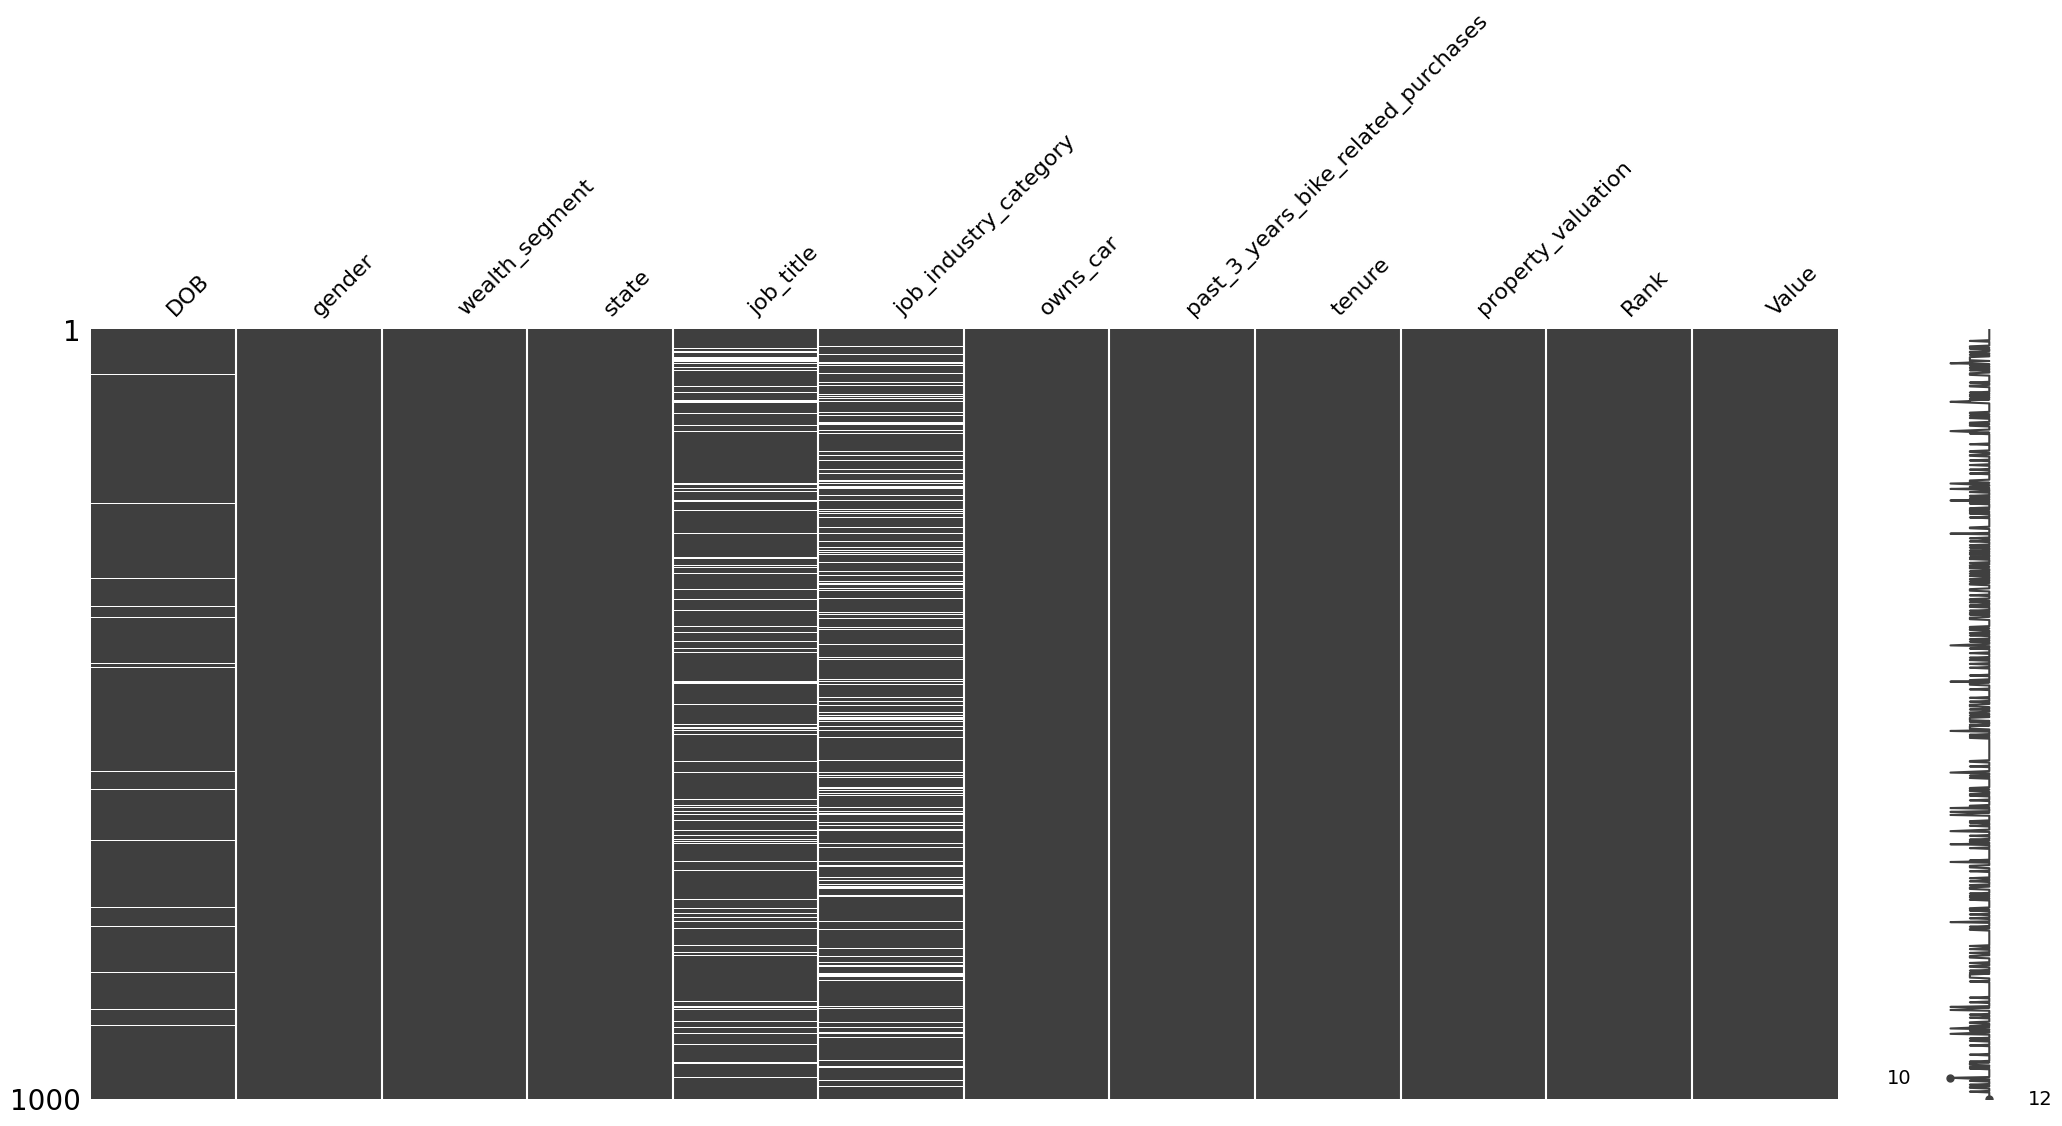

check unique value of each column
gender :
['Female' 'Male' 'U']
---------------------
wealth_segment :
['Affluent Customer' 'High Net Worth' 'Mass Customer']
---------------------
state :
['NSW' 'QLD' 'VIC']
---------------------
job_title :
['Account Coordinator' 'Account Executive' 'Account Representative I'
 'Account Representative II' 'Account Representative III'
 'Account Representative IV' 'Accountant I' 'Accountant II'
 'Accountant III' 'Accountant IV' 'Accounting Assistant I'
 'Accounting Assistant II' 'Accounting Assistant III'
 'Accounting Assistant IV' 'Actuary' 'Administrative Assistant I'
 'Administrative Assistant II' 'Administrative Officer'
 'Analog Circuit Design manager' 'Analyst Programmer' 'Assistant Manager'
 'Assistant Media Planner' 'Assistant Professor' 'Associate Professor'
 'Automation Specialist I' 'Automation Specialist II'
 'Automation Specialist III' 'Automation Specialist IV'
 'Biostatistician IV' 'Budget/Accounting Analyst I'
 'Budget/Accounting Analyst

gender  wealth_segment   
Female  Affluent Customer    53.477876
        High Net Worth       52.588235
        Mass Customer        52.291667
Male    Affluent Customer    48.827869
        High Net Worth       51.601770
        Mass Customer        52.834043
U       Affluent Customer          NaN
        High Net Worth             NaN
        Mass Customer              NaN
Name: age, dtype: float64

**************************************************


,job_industry_category,job_title
0,Argiculture,"[Analog Circuit Design manager, Senior Sales A..."
1,Entertainment,Assistant Media Planner
2,Financial Services,Unknown
3,Health,Unknown
4,IT,Unknown
5,Manufacturing,Unknown
6,Property,Unknown
7,Retail,Sales Representative
8,Telecommunications,"[Human Resources Manager, Structural Engineer,..."
9,Unknown,Unknown


In [35]:
# Report Data quality issue: -----------------------------------------------------------------------------------------
# Missing Value including DOB(17), job_title(106), job_industry_category(165), undefined gender (17)
NewCustomer_df = NewCustomer_df[cols]
print('check missing value of each column')
print(NewCustomer_df.isnull().sum())
print('*'*50)
print('undefined gender: ',len(NewCustomer_df[NewCustomer_df['gender'] == 'U']))
print('*'*50)
msno.matrix(NewCustomer_df)
plt.show()

# Check data consistency ------------------------------
print('check unique value of each column')
for col in NewCustomer_df[cat_cols]:
    print(col,':')
    print(NewCustomer_df[col].sort_values().unique())
    print('---------------------')

# Create age from DOB
NewCustomer_df['age'] = (pd.to_datetime('now') - pd.to_datetime(NewCustomer_df['DOB'], format='%Y-%m-%d')).astype('<m8[Y]')
NewCustomer_df['gender'] = NewCustomer_df['gender'].fillna('Unknown')
NewCustomer_df['job_industry_category'] = NewCustomer_df['job_industry_category'].fillna('Unknown')
NewCustomer_df['job_title'] = NewCustomer_df['job_title'].fillna('Unknown')

# Dealing with missing value ------------------------------
# Imputeing missing of 'age' with mean where has the same 'gender' and 'wealth_segment'
  # However, All of the missing age also contains missing gender, instead of imputing the missing, we will drop as it is 1.7% of dataset
mean_age_group = NewCustomer_df.groupby(['gender', 'wealth_segment'])['age'].mean()
display(mean_age_group)
NewCustomer_df = NewCustomer_df.dropna(subset=['age'])
print('*'*50)

# Imputeing missing of 'job_title' and 'job_industry_category' with their mode where has the same 'gender' and 'wealth_segment'
  # However, mode of this condition also nan value. Instead of dropping, We keep them as Unknown before encoding
mode_job_title_group = NewCustomer_df.groupby([ 'job_industry_category'])['job_title'].agg(pd.Series.mode).reset_index()
display(mode_job_title_group)

NewCustomer_prep = NewCustomer_df.copy()

##1.2 Feature encoding
 Encode all feature and data types to be consistent with training model

In [36]:
# Feature Engineering -----------------------------------------------------------------------------------------
# Create log-transformed feature of age and tenure feature and drop original columns
Log_age = np.log(NewCustomer_df['age'] + 1)
Log_tenure = np.log(NewCustomer_df['tenure'] + 1)
NewCustomer_df['Log_age_tenure'] = Log_age + Log_tenure

# Encode job_cluster from the Hierarchical Clustering
job_cluster_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kpmg/Results/job_cluster_df.csv', index_col=0)
NewCustomer_df = NewCustomer_df.merge(job_cluster_df, on='job_title', how='left')
NewCustomer_df['job_cluster'] = NewCustomer_df['job_cluster'].fillna(41.0) # fill unknown group with new cluster
NewCustomer_df.drop(['DOB','age', 'tenure','job_title','Rank','Value'], axis=1, inplace=True)

# Encode ordinal feature (wealth_segment)
ordinal_encoder = OrdinalEncoder(categories=[['Mass Customer', 'High Net Worth', 'Affluent Customer']])
NewCustomer_df['wealth_segment'] = ordinal_encoder.fit_transform(NewCustomer_df[['wealth_segment']])
NewCustomer_df['owns_car'].replace(to_replace=['Yes', 'No'],
           value= [True, False],
           inplace=True)
# Reorder
col_order = ['gender', 'wealth_segment', 'state', 'job_industry_category',
       'owns_car', 'past_3_years_bike_related_purchases', 'property_valuation',
       'job_cluster', 'Log_age_tenure']
NewCustomer_df = NewCustomer_df[col_order]

# Dummies
categorical_cols = ['gender', 'state','job_industry_category', 'owns_car','job_cluster']
NewCustomer_df = pd.get_dummies(NewCustomer_df, columns=categorical_cols)
# drop columns 'job_industry_category_Unknown', 'job_cluster_41.0' after dummies to make it consistent with trained model
NewCustomer_df.drop(['job_industry_category_Unknown', 'job_cluster_41.0'], axis=1, inplace=True)

# Make data type consistent with training model------------------------------------------------------------
NewCustomer_df.index.name = 'customer_id'
NewCustomer_df[['past_3_years_bike_related_purchases','property_valuation']] = NewCustomer_df[['past_3_years_bike_related_purchases','property_valuation']].astype('float64')
# Select only columns that are of float type and round them to 6 decimal places
float_col = NewCustomer_df.select_dtypes(include=['float64']).columns
for col in float_col:
    NewCustomer_df[col] = NewCustomer_df[col].apply(lambda x: f"{x:.6f}")
    NewCustomer_df[col] = NewCustomer_df[col].astype(float)

print(NewCustomer_df.info())
NewCustomer_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 61 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   wealth_segment                            983 non-null    float64
 1   past_3_years_bike_related_purchases       983 non-null    float64
 2   property_valuation                        983 non-null    float64
 3   Log_age_tenure                            983 non-null    float64
 4   gender_Female                             983 non-null    uint8  
 5   gender_Male                               983 non-null    uint8  
 6   state_NSW                                 983 non-null    uint8  
 7   state_QLD                                 983 non-null    uint8  
 8   state_VIC                                 983 non-null    uint8  
 9   job_industry_category_Argiculture         983 non-null    uint8  
 10  job_industry_category_Entertainment   

,wealth_segment,past_3_years_bike_related_purchases,property_valuation,Log_age_tenure,gender_Female,gender_Male,state_NSW,state_QLD,state_VIC,job_industry_category_Argiculture,...,job_cluster_31.0,job_cluster_32.0,job_cluster_33.0,job_cluster_34.0,job_cluster_35.0,job_cluster_36.0,job_cluster_37.0,job_cluster_38.0,job_cluster_39.0,job_cluster_40.0
customer_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,86.0,6.0,6.912743,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,69.0,11.0,6.822197,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,10.0,5.0,6.309918,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,64.0,1.0,5.598422,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2.0,34.0,9.0,7.073270,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,2.0,60.0,7.0,6.476972,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
979,0.0,22.0,10.0,5.081404,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
980,2.0,17.0,2.0,7.021084,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2.0 Predict on New Dataset
- Load Trained Model
- Apply Scalar from Training Set
- Make a Prediction

###2.1 Model 1: Inactive Customer Identification
Target Classes:
 - non-active (0)
 - active customer (1)



In [37]:
# Load the first model and scaler
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model1.h5')
with open('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/scaler1.pkl', 'rb') as file:
    scaler1 = pickle.load(file)

# apply scaling
X_scaled_1 = scaler1.transform(NewCustomer_df)
# Predict label
y_pred_prob_1 = model1.predict(X_scaled_1)
threshold = 0.5
y_pred_labels = (y_pred_prob_1 > threshold).astype(int)

# Add to DataFrame
NewCustomer_df['Predicted_Label'] = y_pred_labels

31/31 [==============================] - 0s 3ms/step


###2.2 Model 2: High-Value Customer Identification
Target Classes:
- low-value customer (0)
- med/ high-value customer (1)

9/9 [==============================] - 0s 6ms/step


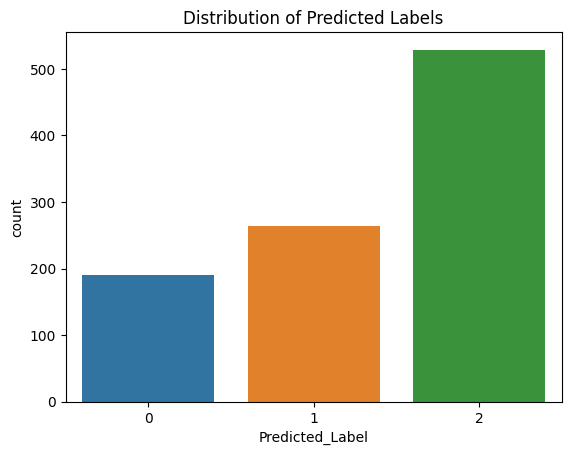

In [39]:
# Filter out active customers
active_customers = NewCustomer_df[NewCustomer_df['Predicted_Label'] == 1]
active_customers = active_customers.drop(['Predicted_Label'], axis=1)

# Load the first model and scaler
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/model2.h5')
with open('/content/drive/MyDrive/Colab Notebooks/kpmg/TrainedModel/scaler2.pkl', 'rb') as file:
    scaler2 = pickle.load(file)

# Apply scaling
X_active_scaled = scaler2.transform(active_customers)
y_pred_prob_2 = model1.predict(X_active_scaled)
threshold = 0.5
y_pred_labels = (y_pred_prob_2 > threshold).astype(int)

# Update predictions in the original DataFrame
# Map 0 to 1 (low value) and 1 to 2 (high value) for the second model's predictions
NewCustomer_df.loc[NewCustomer_df['Predicted_Label'] == 1, 'Predicted_Label'] = y_pred_labels + 1

# Inspect with Bar Plot
sns.countplot(x='Predicted_Label', data=NewCustomer_df)
plt.title('Distribution of Predicted Labels')
plt.show()
NewCustomer_df.to_csv('/content/drive/MyDrive/Colab Notebooks/kpmg/Results/NewCustomer_df.csv')

In [14]:
NewCustomer_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kpmg/Results/NewCustomer_df.csv')
NewCustomer_df
NewCustomer_df[NewCustomer_df.customer_id==59]

,customer_id,wealth_segment,past_3_years_bike_related_purchases,property_valuation,Log_age_tenure,gender_Female,gender_Male,state_NSW,state_QLD,state_VIC,...,job_cluster_32.0,job_cluster_33.0,job_cluster_34.0,job_cluster_35.0,job_cluster_36.0,job_cluster_37.0,job_cluster_38.0,job_cluster_39.0,job_cluster_40.0,Predicted_Label
59,59,1.0,47.0,7.0,6.603944,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,2


#3.0 Convert to Original Columns

In [40]:
NewCustomer_df_num = NewCustomer_df.copy()
categorical_cols = ['gender', 'state','job_industry_category', 'owns_car','job_cluster']
for col in categorical_cols:
    # Get the one-hot encoded columns for this original column
    one_hot_cols = [c for c in NewCustomer_df_num.columns if c.startswith(col + '_')]
    # Reconstruct the original column
    NewCustomer_df_num[col] = NewCustomer_df_num[one_hot_cols].idxmax(axis=1)
    # Extract the category name and remove the prefix
    NewCustomer_df_num[col] = NewCustomer_df_num[col].apply(lambda x: x.split('_')[-1])
    # Drop the one-hot encoded columns
    NewCustomer_df_num.drop(one_hot_cols, axis=1, inplace=True)

In [43]:
# Combine with other original columns
NewCustomer_df_num['age']= NewCustomer_prep['age']
NewCustomer_df_num['tenure'] = NewCustomer_prep['tenure']
NewCustomer_df_num['Rank'] = NewCustomer_prep['Rank']
NewCustomer_df_num['Value'] = NewCustomer_prep['Value']
NewCustomer_df_num['wealth_segment'] = NewCustomer_prep['wealth_segment']
NewCustomer_df_num = NewCustomer_df_num.rename(columns={'customer_id': 'new_customer_id'})
NewCustomer_df_num.to_csv('/content/drive/MyDrive/Colab Notebooks/kpmg/Results/NewCustomer_df_num.csv')

In [44]:
NewCustomer_df_num

,wealth_segment,past_3_years_bike_related_purchases,property_valuation,Log_age_tenure,Predicted_Label,gender,state,job_industry_category,owns_car,job_cluster,age,tenure,Rank,Value
customer_id,,,,,,,,,,,,,,
0,Mass Customer,86.0,6.0,6.912743,2,Male,QLD,Manufacturing,True,8.0,66.0,14.0,1.0,1.718750
1,Mass Customer,69.0,11.0,6.822197,2,Male,NSW,Property,False,2.0,53.0,16.0,1.0,1.718750
2,Affluent Customer,10.0,5.0,6.309918,2,Female,VIC,Financial Services,False,1.0,49.0,10.0,1.0,1.718750
3,Affluent Customer,64.0,1.0,5.598422,2,Female,QLD,Manufacturing,True,33.0,44.0,5.0,4.0,1.703125
4,Affluent Customer,34.0,9.0,7.073270,2,Female,NSW,Financial Services,False,13.0,58.0,19.0,4.0,1.703125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,Mass Customer,60.0,7.0,6.476972,2,Male,NSW,Financial Services,False,0.0,46.0,13.0,979.0,0.416500
979,Mass Customer,22.0,10.0,5.081404,0,Male,NSW,Health,False,40.0,37.0,9.0,979.0,0.416500
980,Mass Customer,17.0,2.0,7.021084,2,Female,QLD,Financial Services,True,29.0,31.0,3.0,979.0,0.416500


scaling for prediction
